## Forecast Models

### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json
from pandas import DataFrame as df

### Forecasting Intro

You are going to choose different models depending upon the data you have. We will train our model on the first group of data (Training Data : 1st 80%). Then we test the model using the last part of our data (Test Date : Last 20%). All along we are modeling using real known true results. We should forecast into the future the same length of time we test for.

### Get Our Data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2020-03-01 to 2020-10-27
Freq: D
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   new_deaths_per_million  241 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21',
               '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25',
               '2020-10-26', '2020-10-27'],
              dtype='datetime64[ns]', name='date', length=241, freq='D')

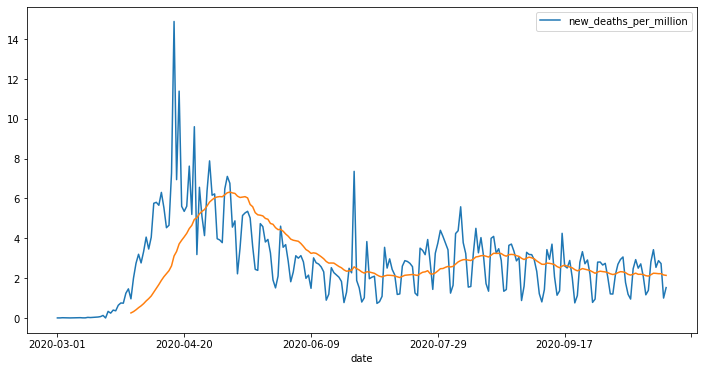

In [33]:
# Import Our World in Data CSV
# https://github.com/owid/covid-19-data/tree/master/public/data
owid_df = pd.read_csv('owid-covid-data.csv')

owid_df.columns # Show all columns

# Create Numpy array of unique countries
covid_df = owid_df.location.unique()
# Get indexes for United States
indexer = owid_df[owid_df['location']=='United States'].index
# Get dataframe location and column data for country name
covid_df = owid_df.loc[indexer, 'date':'new_deaths_per_million']
# Delete NaN values
covid_df = covid_df.dropna()
# Set date as index
covid_df.set_index('date', inplace=True)
# Remove all columns except for what I want
covid_df.drop(covid_df.columns.difference(['new_deaths_per_million']), 1, inplace=True)
covid_df.plot(figsize=(12,6))
# Plot a 30 day moving average
covid_df.rolling(window=30).mean()['new_deaths_per_million'].plot()

covid_df = covid_df.asfreq('d') # Set frequency for daily
# covid_df = covid_df.set_index('date').asfreq('d')
# Get the number of data points we have
covid_df.info() # 241 : 192 Training : 49 Test
# Separate into 2 pieces
train_df = covid_df.iloc[:192]
test_df = covid_df.iloc[191:]

covid_df.index

### Holt-Winters Model with Training Data

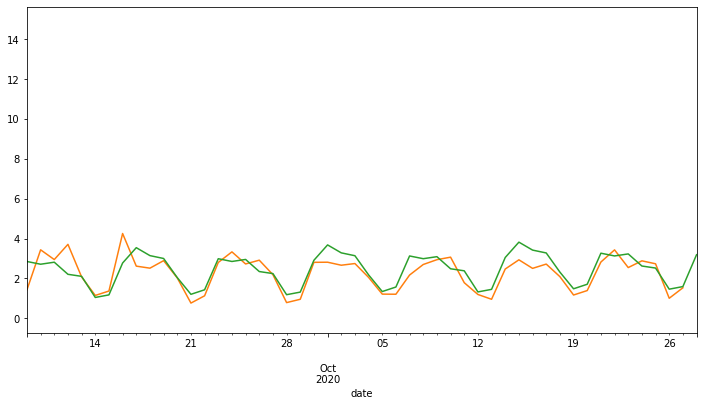

In [84]:
# The Holt - Winters Method actually models 3 aspects of the 
# time series being the average, trend and seasonality. 
# In doing so it tries to predict the future provided the 
# series is seasonal and repetitive over time.

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# There is no exponential growth so I'll use additive
# I picked 14 for period because it provided the best result
fit_model = ExponentialSmoothing(train_df['new_deaths_per_million'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=14).fit()
# We can now make predictions 50 days into the future
prediction = fit_model.forecast(50)
prediction

# Plot training, testing and projection data
train_df['new_deaths_per_million'].plot(figsize=(12,6))
test_df['new_deaths_per_million'].plot()
prediction.plot(xlim=['2020-09-09','2020-10-28'])


### Evaluating Predictions : Mean Absolute Error

I'll look at different options for evaluating my forecasts being Mean Absolute, Mean Squared and Root Mean Square Error.

Mean Absolute Error : Take the difference between our prediction and the true result and find the average. The negative is that a few major errors my skew the results.

\begin{equation*}
\frac{1}{n}\sum_{n}^{i=1}|y_i - \hat{y}_i|
\end{equation*}


In [90]:
def mae(y1, y2, axis=0):
    y1_np = y1.to_numpy()
    y2_np = y2.to_numpy()
    return np.mean(np.abs(y1_np - y2_np), axis=axis)

mae(test_df, prediction, None)

# We'll use the scikit-learn library
# conda install scikit-learn or
# pip install -U scikit-learn

from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_absolute_error(test_df, prediction)
# test_df.mean() # How good are our results


0.9621518089453235

### Mean Squared Error

Mean Squared Error : Takes the difference like before and finds the mean, but since we square the results large errors are squared which dramatically shows those errors in the model. The negative is that the units are squared distorting the results.

\begin{equation*}
\frac{1}{n}\sum_{n}^{i=1}({y_i - \hat{y}_i})^2
\end{equation*}

In [80]:
def mse(y1, y2, axis=0):
    y1_np = y1.to_numpy()
    y2_np = y2.to_numpy()
    return ((y1_np - y2_np) ** 2).mean(axis=axis)
# axis=0 is per-column, ax=1 is per-row and ax=None is total 
mse(test_df, prediction, None)
    
mean_squared_error(test_df, prediction)


0.9722424604387213

### Root Mean Squared Error

Root Mean Squared Error : By finding the square root we return to the original unit used. When evaluating how bad an error is it depends on how large your values are. If we found our model was off by 100,000 nationally that wouldn't be as big a deal as if we were off by 100,000 in a small city.

\begin{equation*}
\sqrt{\frac{1}{n}\sum_{n}^{i=1}({y_i - \hat{y}_i})^2}
\end{equation*}

In [85]:
np.sqrt(mean_squared_error(test_df, prediction))

0.9860235597787314

### Predict the Future

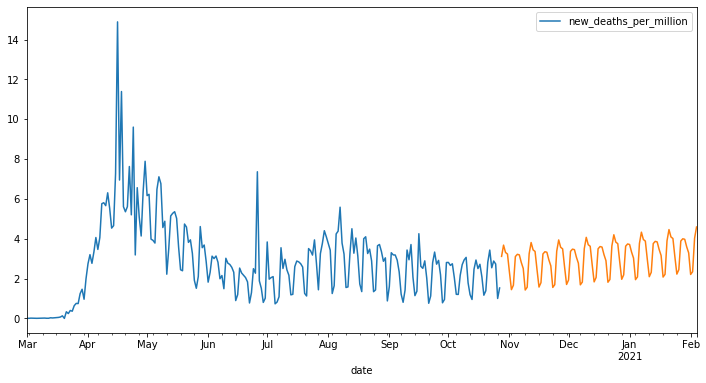

In [98]:
covid_model = ExponentialSmoothing(covid_df['new_deaths_per_million'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=14).fit()
# Let's predict 100 days into the future
covid_forecast = covid_model.forecast(100)
# Print original and then our prediction
covid_df.plot(figsize=(12,6))
covid_forecast.plot()

### ARIMA Model (Auto Regression)

AutoRegressive Integrated Moving Average (ARIMA) is the basis for many other models. It focuses on trying to fit the data as well as possible by examining differences between values instead of the values themselves. 

ARIMA works very well when data values have a clear trend and seasonality. We can only make predictions based on the data we have. Any outside effects not in the data can't be used to make predictions. For example we could make predictions on stock prices, but since we don't know when a recession may occur that event can't be modeled.

There is a seasonal (SARIMA) and a non-seasonal ARIMA. There is also SARIMAX which focuses on exogenous, or external factors. It differs from ARIMA in that it has a set of parameters (P, D, and Q) that focus on seasonality.

AR (Autoregressions) refers to a model that regresses based on prior values. 

### Regression Example

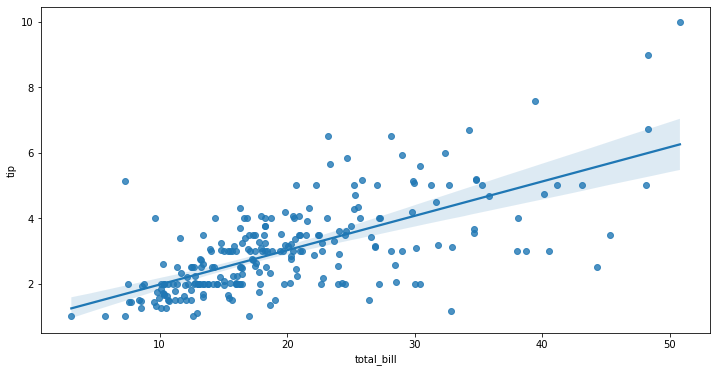

In [170]:
# Our prediction is that as the bill amount increases
# so does the tip. Create a regression line to check
# Load tip dataset
tips = sns.load_dataset("tips")
# Create a regression line that averages the results
plt.figure(figsize=(12,6))
sns.regplot(x="total_bill", y="tip", data=tips)

### Regression Time Series Example with AutoReg

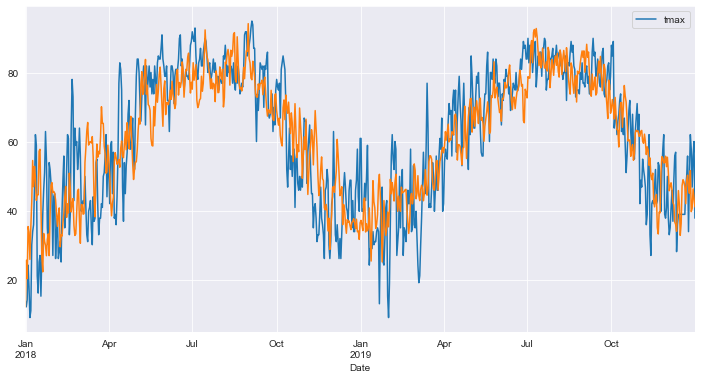

In [404]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

pitt_df = pd.read_csv('PittsburghWeather.csv', index_col='Date', parse_dates=True)
pitt_df = pitt_df.drop(['tmin', 'prcp'], axis=1)

# Get data since 2010
pitt_df = pitt_df[pitt_df.index>'2010-01-01']
pitt_df = pitt_df.asfreq('d') # Change frequency to day
pitt_df = pitt_df.fillna(method='ffill')
pitt_df.index # Check frequency
pitt_df.isnull().values.any() # Check for NaNs

# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(12, 6))

# Plot daily max temps
fig, ax = plt.subplots()
# ax = pitt_df.plot(ax=ax)

# Create our model using whole data set
model = AutoReg(pitt_df['tmax'], 30)
model_fit = model.fit()

# Define training and testing area
len(pitt_df) # 3651 observations
train_df = pitt_df.iloc[:2920] # 80%
test_df = pitt_df.iloc[2920:] # Last 20%

# Define training model for 730 days and White's covariance
# estimator
train_model = AutoReg(train_df['tmax'], 730).fit(cov_type="HC0")

start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax)
ax = prediction.plot(ax=ax)



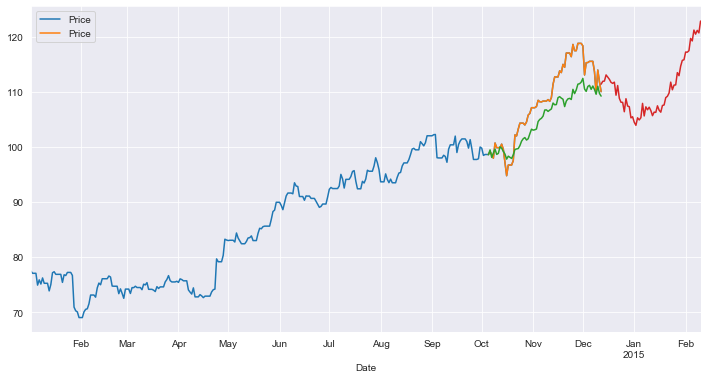

In [428]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

appl_df = pd.read_csv('appl2.csv', index_col='Date', parse_dates=True)

appl_df = appl_df.asfreq('d') # Change frequency to day
appl_df = appl_df.fillna(method='ffill')
appl_df.index # Check frequency
appl_df.isnull().values.any() # Check for NaNs

# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(12, 6))

# Plot daily max temps
fig, ax = plt.subplots()
ax = appl_df.plot(ax=ax)

# Create our model using whole data set
model = AutoReg(appl_df['Price'], 30)
model_fit = model.fit()

# Define training and testing area
len(appl_df) # 345 observations
train_df = appl_df.iloc[:276] # 80%
test_df = appl_df.iloc[276:] # Last 20%

# Define training model for 100 days and White's covariance
# estimator
train_model = AutoReg(appl_df['Price'], 100).fit(cov_type="HC0")

# Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # Orange
ax = prediction.plot(ax=ax) # Green

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+60, dynamic=True)
ax = forecast.plot(ax=ax) # Red

### ARIMA (Integrated)

I (Integrated) focuses on replacing values with the differences between previous values. Differencing is the computing of the differences between consecutive values. The goal is to make the time series stationary.

A stationary series has a constant mean and variance.

### Stationary Datasets

Dickey-Fuller Test
Test Statistic                -1.251942e+01
p-value                        2.568080e-23
#Lags Used                     3.300000e+01
Number of Observations Used    5.444000e+03
dtype: float64
Dickey-Fuller Test
Test Statistic                  -0.339865
p-value                          0.919665
#Lags Used                       0.000000
Number of Observations Used    239.000000
dtype: float64


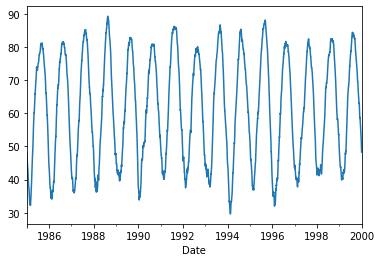

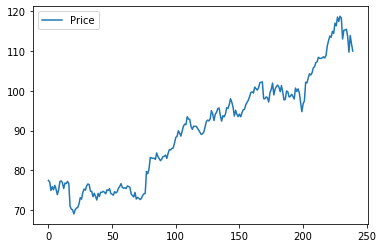

In [173]:
# Your data must be transformed to stationary form it to stationary
# form to be able to evaluate it

# Used to measure whether our data is stationary
from statsmodels.tsa.stattools import adfuller

# Stationary data is rather flat and the mean, variance 
# and autocorrelation structure do not change over time.
# This data isn't perfect because variance is changing
pitt_df = pd.read_csv('PittsburghWeather.csv', 
                      index_col='Date', parse_dates=True)
# pitt_df['tmax'].plot(xlim=['1985-01-01','2000-01-01'])

# Flatten it out a bit by finding the mean
df_2 = pitt_df.rolling(window=60).mean()['tmax']
# Mask off dates and return them to the dataframe
mask = (df_2.index > '1985-01-01') & (df_2.index <= '2000-01-01')
df_2 = df_2.loc[mask]
df_2.plot()

# Example of non-stationary data US Birth rates 30-34
usbr_df = pd.read_csv('US-Birth-Rates.csv', 
                      index_col='Year', parse_dates=True)
# usbr_df['30-34'].plot()

# Another non-stationary example
# Import stock data from a CSV file
df_appl = pd.read_csv('appl2.csv')
df_appl.plot()

# The Augmented Dickey-Fuller Test tells us whether our results
# are stationary. If the P-Value is very small that means
# there is a very low probability that our reults are random
def adf_test(timeseries):
    print ('Dickey-Fuller Test')
    # AIC aims to minimize corresponding information
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (dfoutput)

# Highly stationary (Low P-Value)
adf_test(df_2)

# Not stationary (High P-Value)
adf_test(df_appl['Price'])
